In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import quantum_info
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.classical import expr
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

import matplotlib.pyplot as plt
import numpy as np

### GHZ State using direct and dynamic approaches

#### Direct Circuit

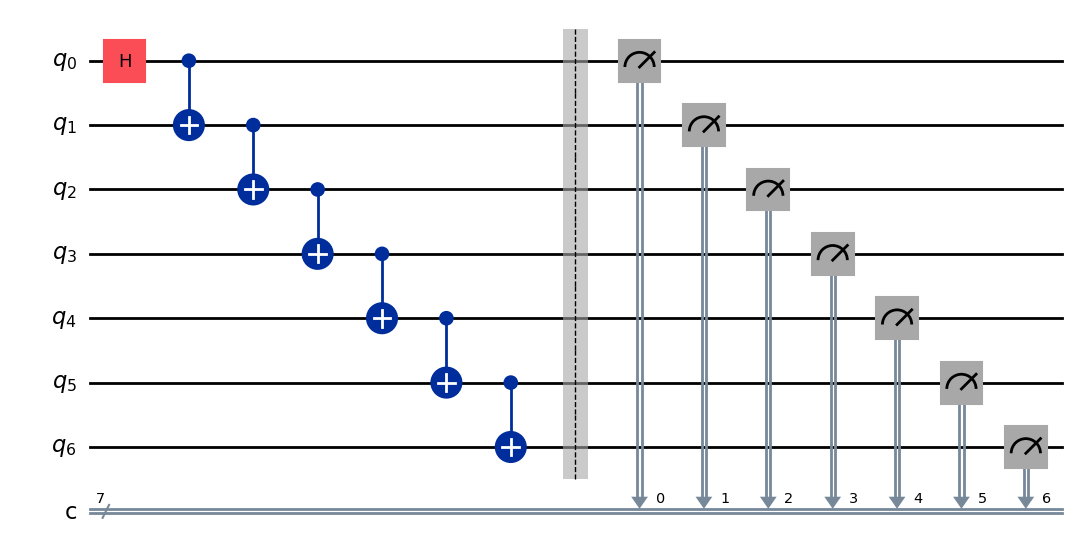

In [ ]:
direct_circuit = QuantumCircuit(7, 7)

direct_circuit.h(0)
direct_circuit.cx(0, 1)
direct_circuit.cx(1, 2)
direct_circuit.cx(2, 3)
direct_circuit.cx(3, 4)
direct_circuit.cx(4, 5)
direct_circuit.cx(5, 6)
direct_circuit.barrier()
direct_circuit.measure(list(range(7)), list(range(7)))

direct_circuit.draw('mpl')


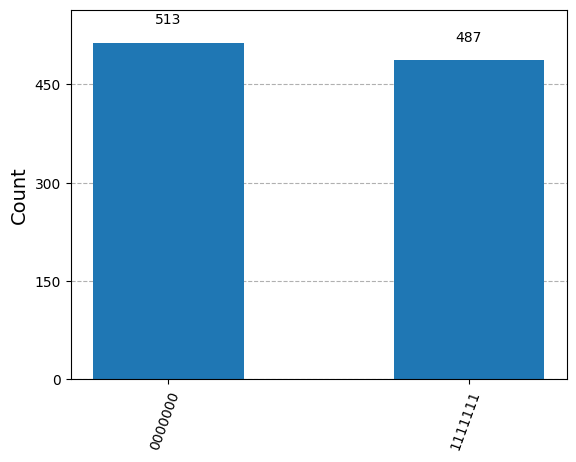

In [ ]:
backend = AerSimulator()
sampler = Sampler(backend)
direct_circuit = transpile(direct_circuit, backend=backend)
result = sampler.run([direct_circuit], shots=1000).result()
plot_histogram(result[0].data.c.get_counts())
# print('result: ', result[0].data.c2.get_counts())

In [ ]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_kyoto')
sampler = Sampler(backend)

direct_circuit_tp = transpile(direct_circuit, backend=backend)
job_id = sampler.run([direct_circuit_tp], shots=1000).job_id()

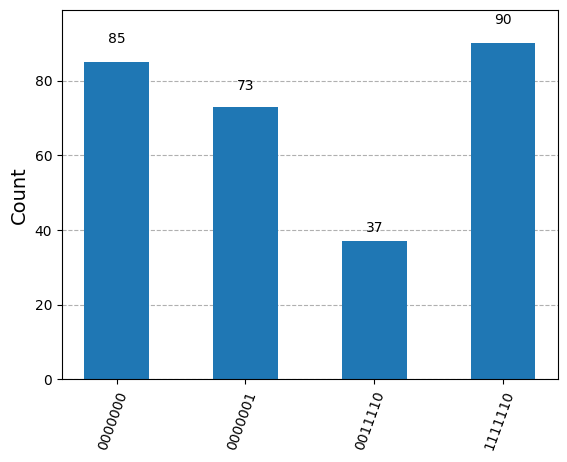

In [ ]:
result = service.job('ct7bfx7qsez00089w91g').result()
stats = result[0].data.c.get_counts()
states = sorted(stats, key = lambda x: stats[x])[::-1]

sub_counts = {}
for i in range(4):
    sub_counts[states[i]] = stats[states[i]]

direct_crt_counts = sub_counts
plot_histogram(sub_counts)


#### ------------------------------------------------------------------------------------------------

#### Dynamic circuit

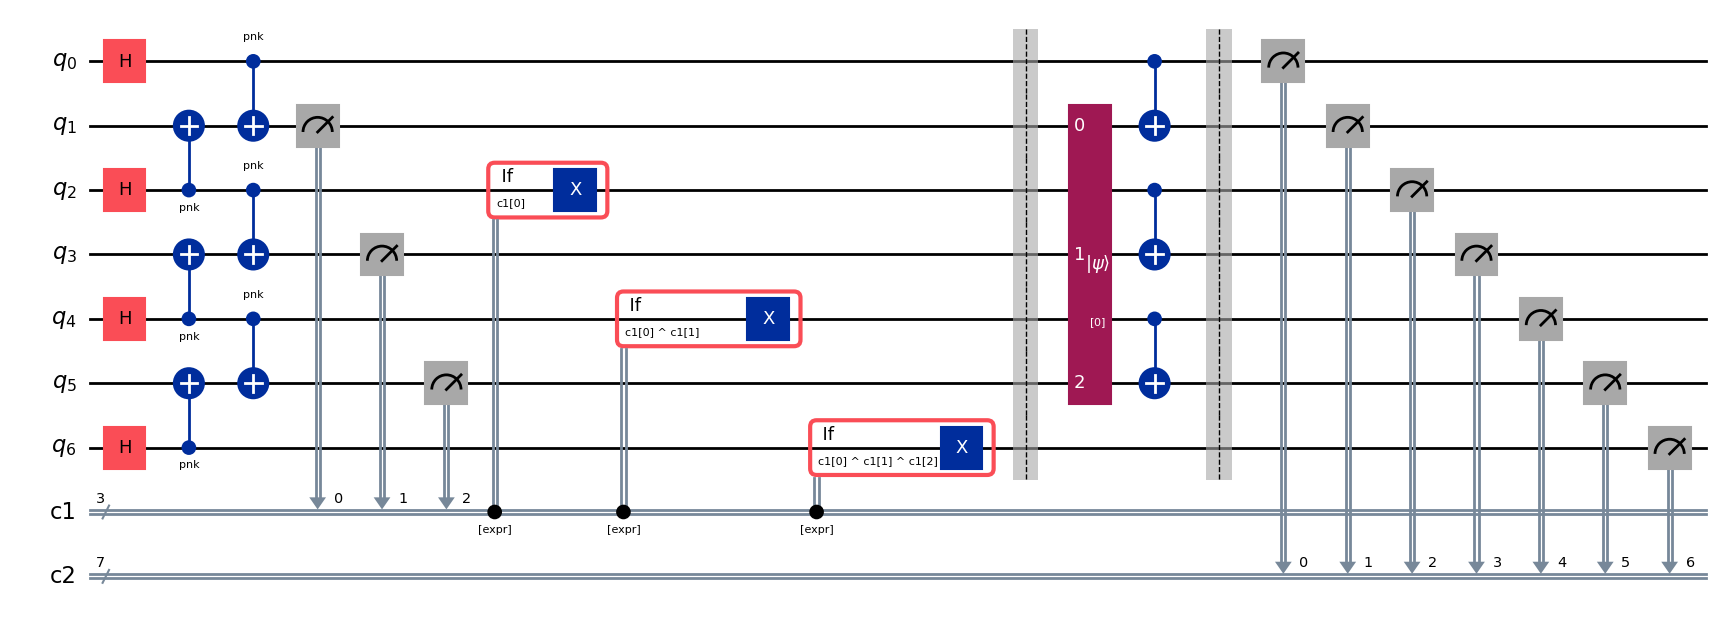

In [ ]:
q = QuantumRegister(7, 'q')
c1 = ClassicalRegister(3, 'c1')
c2 = ClassicalRegister(7, 'c2')
circuit2 = QuantumCircuit(q, c1, c2)

circuit2.h([0, 2, 4, 6])

circuit2.cx(2, 1, 'pnk')

circuit2.cx(4, 3, 'pnk')

circuit2.cx(6, 5, 'pnk')


circuit2.cx(0, 1, 'pnk')

circuit2.cx(2, 3, 'pnk')

circuit2.cx(4, 5, 'pnk')

circuit2.measure([1, 3, 5], c1)


with circuit2.if_test(expr.lift(c1[0])):
    circuit2.x(2)

with circuit2.if_test(expr.bit_xor(c1[0], c1[1])):
    circuit2.x(4)

c1_c2_xor = expr.bit_xor(c1[0], c1[1])
with circuit2.if_test(expr.bit_xor(c1_c2_xor, c1[2])):    
    circuit2.x(6)


circuit2.barrier()
circuit2.initialize(0, [1, 3, 5])

circuit2.cx(0, 1)
circuit2.cx(2, 3)
circuit2.cx(4, 5)

circuit2.barrier()
circuit2.measure(q, c2)

circuit2.draw('mpl')

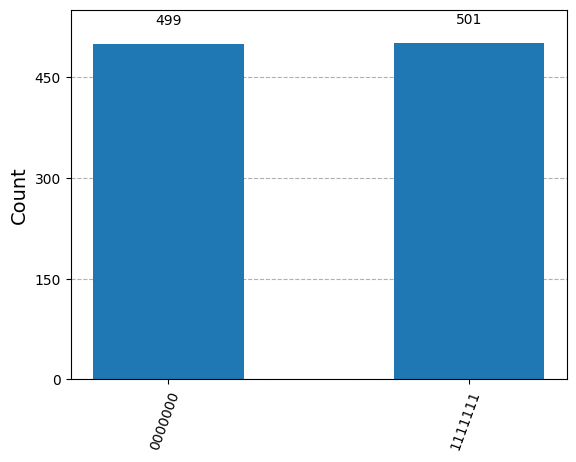

In [ ]:
backend = AerSimulator()
sampler = Sampler(backend)
circuit2_tp = transpile(circuit2, backend=backend)
result = sampler.run([circuit2_tp], shots=1000).result()
plot_histogram(result[0].data.c2.get_counts())
# print('result: ', result[0].data.c2.get_counts())

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.get_backend('ibm_kyoto')
sampler = Sampler(backend)

circuit2_tp = transpile(circuit2, backend=backend)

job_id = sampler.run([circuit2_tp], shots=1000).job_id()

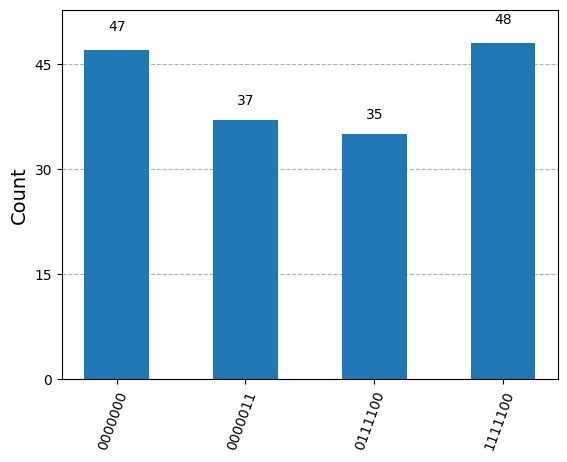

In [ ]:
result = service.job('ct7bme13b8m0008c3mng').result()
stats = result[0].data.c2.get_counts()

states = sorted(stats, key = lambda x: stats[x])[::-1]

sub_counts = {}
for i in range(4):
    sub_counts[states[i]] = stats[states[i]]
dynamic_crt_counts = sub_counts
plot_histogram(sub_counts)

### Comparing results of Direct & Dynamic on IBM Kyoto

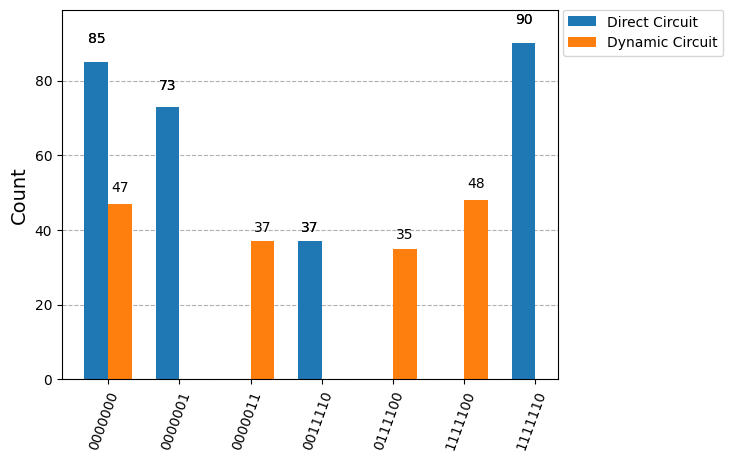

In [ ]:
plot_histogram([direct_crt_counts, dynamic_crt_counts], legend=('Direct Circuit', 'Dynamic Circuit'))